<a href="https://colab.research.google.com/github/UQROO-MarianaJetzuvelyGarciaHau/Colab-Tareas/blob/main/ProyectoMariana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Preparación e Instalación**

In [21]:
# Instalar la biblioteca Platypus
!pip install platypus-opt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from platypus import NSGAII, Problem, Integer

**Descarga y Análisis de Datos**

In [22]:
#Cargar el archivo de datos
file_id = 'sample_data/80128_prueba_kwh.csv'
df = pd.read_csv(file_id)


# Mostrar las primeras filas y los tipos de datos para verificación
print("--- Primeras filas ---")
print(df.head())
print("\n--- Información del DataFrame ---")
print(df.info())

# Renombrar columnas para facilitar el uso
print("\n--- Renombrar las columnas---")
print(df.columns.tolist())
df.columns = ['irradiancia', 'velocidadviento', 'carga']


--- Primeras filas ---
   irradiancia  velocidadviento      carga
0        0.311              4.0  10.547120
1        0.000              3.2  10.264410
2        0.000              3.4   9.134468
3        0.000              3.2   2.892932
4        0.000              5.2   0.118024

--- Información del DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   irradiancia      8760 non-null   float64
 1   velocidadviento  8760 non-null   float64
 2   carga            8760 non-null   float64
dtypes: float64(3)
memory usage: 205.4 KB
None

--- Renombrar las columnas---
['irradiancia', 'velocidadviento', 'carga']


**Cálculo de Energía Generada y Balance Energético**

Aplicaremos las fórmulas proporcionadas para calcular la energía generada por una sola unidad de cada tecnología y escribiremos las constantes.

In [23]:
#Constantes------------------------------------------------

# Panel solar
AREA_PANEL = 1.6
EFICIENCIA_PANEL = 0.18

# Aerogenerador
RADIO_ROTOR = 20
COEFICIENTE_POTENCIA = 0.4
DENSIDAD_AIRE = 1.225

FACTOR_CONVERSION = 1000  # Para pasar de W a kW, o de J/s a kWh si se asume un periodo de 1h

AREA_ROTOR = np.pi * (RADIO_ROTOR**2)

# Cálculo de la energía generada por una UNIDAD de cada uno (en kWh)
# Energía Solar (kWh) por panel
df['energia_solar_unidad'] = (df['irradiancia'] * AREA_PANEL * EFICIENCIA_PANEL) / FACTOR_CONVERSION

# Energía Eólica (kWh) por aerogenerador
# La fórmula dada asume que la potencia (en W) se convierte a energía (kWh) en un periodo de 1 hora.
df['energia_eolica_unidad'] = (0.5 * DENSIDAD_AIRE * AREA_ROTOR * (df['velocidadviento']**3) * COEFICIENTE_POTENCIA) / FACTOR_CONVERSION

# Imprimimos los resultados
print("--- Energía generada por unidad (Primeras filas) ---")
print(df[['irradiancia', 'velocidadviento', 'carga', 'energia_solar_unidad', 'energia_eolica_unidad']].head())


--- Energía generada por unidad (Primeras filas) ---
   irradiancia  velocidadviento      carga  energia_solar_unidad  \
0        0.311              4.0  10.547120               0.00009   
1        0.000              3.2  10.264410               0.00000   
2        0.000              3.4   9.134468               0.00000   
3        0.000              3.2   2.892932               0.00000   
4        0.000              5.2   0.118024               0.00000   

   energia_eolica_unidad  
0              19.704069  
1              10.088483  
2              12.100761  
3              10.088483  
4              43.289840  


**Planteamiento del Problema de Optimización con Platypus**

El objetivo es encontrar el número de paneles solares y aerogeneradores que minimice el déficit energético total a lo largo de todo el periodo de datos.

In [24]:
 # Almacenar las series de datos necesarias
E_SOL_UNIDAD = df['energia_solar_unidad'].values
E_EOL_UNIDAD = df['energia_eolica_unidad'].values
CARGA = df['carga'].values
demanda_total = CARGA.sum()

# Definir la función objetivo
def balance_energetico(vars):

  # Objetivo 1: minimizar déficit total
  N_sol = vars[0] # Número de páneles
  N_eol = vars[1]  # Número de aerogeneradores

  # Energía generada total en cada instante de tiempo
  generacion_total = (N_sol * E_SOL_UNIDAD) + (N_eol * E_EOL_UNIDAD)
  deficit_por_tiempo = CARGA - generacion_total #balance
  deficit_total = np.sum(np.maximum(0, deficit_por_tiempo))

  # Objetivo 2: minimizar número total de equipos (Nsol + Neol)
  equipos = N_sol + N_eol

  # Objetivo 3: Excedente (energía sobrante)
  excedente_total = np.sum(np.maximum(0, - deficit_por_tiempo))

  return [deficit_total, equipos, excedente_total]

# Implementación del Problema con Platypus -------------------------
problem = Problem(2, 3) # 2 variables, 3 objetivos

# Definir los tipos de variables y sus límites
MAX_PANELS = 200
MAX_AEROGENERADORES = 2
problem.types[:] = [
    Integer(0, MAX_PANELS),         # N_sol
    Integer(0, MAX_AEROGENERADORES)  # N_eol
]

# Asignar la función de evaluación al problema
problem.function = balance_energetico
problem.directions[:] = [Problem.MINIMIZE, Problem.MINIMIZE, Problem.MINIMIZE]

# Elegir y crear la instancia del algoritmo
algorithm = NSGAII(problem)

# Ejecutar la optimización
N_EVALUATIONS = 8000
print(f"\n Ejecutando el algoritmo NSGAII con {N_EVALUATIONS} evaluaciones... ")
algorithm.run(N_EVALUATIONS)

# Extraer y mostrar la mejor solución
best_solution = min(algorithm.result, key=lambda s: s.objectives[0])

# Decodificar los binarios a enteros
Nu_Paneles = problem.types[0].decode(best_solution.variables[0])
Nu_eol = problem.types[1].decode(best_solution.variables[1])
def_fin = best_solution.objectives[0]

print("\n--- SOLUCIÓN ÓPTIMA (Mínimo Déficit) ---")
print(f"**Criterio de Optimización:** Mínimo Déficit Energético")
print(f" \nCantidad de Paneles: {Nu_Paneles}")
print(f"Cantidad de Aerogeneradores: {Nu_eol}")
print(f"Déficit Anual Restante: {def_fin:,.2f} kWh")




 Ejecutando el algoritmo NSGAII con 8000 evaluaciones... 

--- SOLUCIÓN ÓPTIMA (Mínimo Déficit) ---
**Criterio de Optimización:** Mínimo Déficit Energético
 
Cantidad de Paneles: 200
Cantidad de Aerogeneradores: 2
Déficit Anual Restante: 15,509.62 kWh


**Reporte detallado**

In [28]:
def informe(nombre, solucion):

    # Recuperamos las variables (equipos)
    Nsol = problem.types[0].decode(solucion.variables[0])
    Neol = problem.types[1].decode(solucion.variables[1])

    # Resultados del algoritmo
    deficit = solucion.objectives[0]
    equipos = solucion.objectives[1]
    excedente = solucion.objectives[2]

    #Operaciones matemáticas
    generacion_horaria = (Nsol * E_SOL_UNIDAD) + (Neol * E_EOL_UNIDAD)
    generacion_total = generacion_horaria.sum()

    cobertura = (1 - deficit / demanda_total) * 100

    print(f"\n========== {nombre} ==========")
    print(f"Paneles: {Nsol}")
    print(f"Aerogeneradores: {Neol}")
    print(f"Total de equipos: {equipos}")
    print(f"Generación total: {generacion_total:,.2f} kWh")
    print(f"Demanda total: {demanda_total:,.2f} kWh")
    print(f"Déficit total: {deficit:,.2f} kWh")
    print(f"Excedente total: {excedente:,.2f} kWh")
    print(f"Cobertura de demanda: {cobertura:.2f}%")
    print("=========================================")


orden_deficit = sorted(algorithm.result, key=lambda s: s.objectives[0])
orden_equipos = sorted(algorithm.result, key=lambda s: s.objectives[1])
orden_excedente = sorted(algorithm.result, key=lambda s: s.objectives[2])

informe("1) Mínimo déficit (Autosuficiencia máxima)", orden_deficit[0])
informe("2) Solución equilibrada", orden_deficit[len(orden_deficit)//2])
informe("3) Mínimo número de equipos", orden_equipos[0])
informe("4) Mínimo excedente", orden_excedente[0])


========== 1) Mínimo déficit (Autosuficiencia máxima) ==========
Paneles: 200
Aerogeneradores: 2
Total de equipos: 202
Generación total: 254,991.79 kWh
Demanda total: 44,082.16 kWh
Déficit total: 15,509.62 kWh
Excedente total: 226,419.25 kWh
Cobertura de demanda: 64.82%

========== 2) Solución equilibrada ==========
Paneles: 30
Aerogeneradores: 1
Total de equipos: 31
Generación total: 77,183.23 kWh
Demanda total: 44,082.16 kWh
Déficit total: 19,930.33 kWh
Excedente total: 53,031.40 kWh
Cobertura de demanda: 54.79%

========== 3) Mínimo número de equipos ==========
Paneles: 0
Aerogeneradores: 0
Total de equipos: 0
Generación total: 0.00 kWh
Demanda total: 44,082.16 kWh
Déficit total: 44,082.16 kWh
Excedente total: 0.00 kWh
Cobertura de demanda: 0.00%

========== 4) Mínimo excedente ==========
Paneles: 0
Aerogeneradores: 0
Total de equipos: 0
Generación total: 0.00 kWh
Demanda total: 44,082.16 kWh
Déficit total: 44,082.16 kWh
Excedente total: 0.00 kWh
Cobertura de demanda: 0.00%


**Gráfica de pareto**



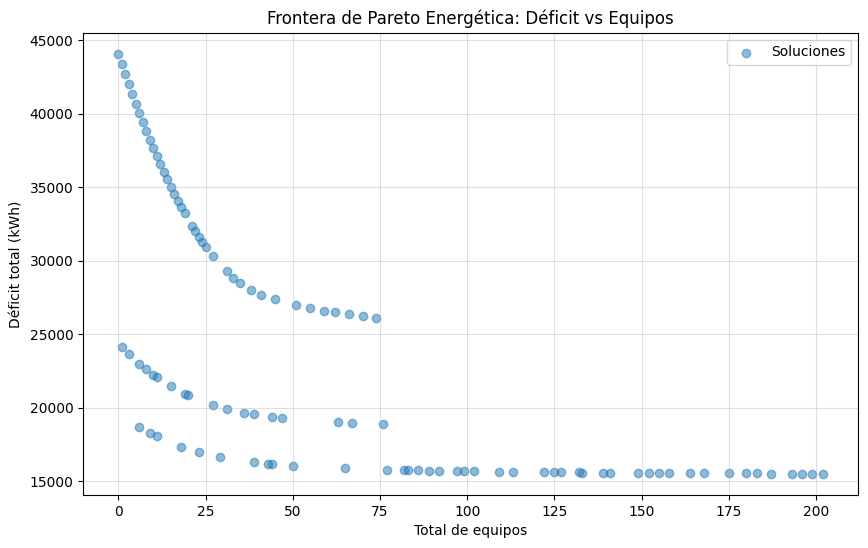

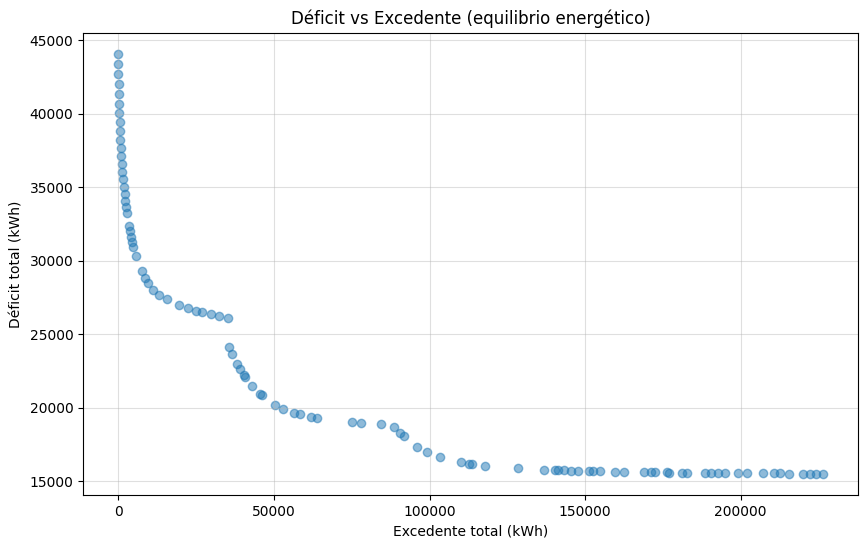

In [26]:
deficits = [s.objectives[0] for s in algorithm.result]
equipos = [s.objectives[1] for s in algorithm.result]
excedentes = [s.objectives[2] for s in algorithm.result]

plt.figure(figsize=(10,6))
plt.scatter(equipos, deficits, alpha=0.5, label="Soluciones")
plt.xlabel("Total de equipos")
plt.ylabel("Déficit total (kWh)")
plt.title("Frontera de Pareto Energética: Déficit vs Equipos")
plt.grid(alpha=0.4)
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(excedentes, deficits, alpha=0.5)
plt.xlabel("Excedente total (kWh)")
plt.ylabel("Déficit total (kWh)")
plt.title("Déficit vs Excedente (equilibrio energético)")
plt.grid(alpha=0.4)
plt.show()